In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gym
import torch
from matplotlib.ticker import PercentFormatter
from torch import nn
from gym import spaces
import random
from collections import deque
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch as th
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D,SimpleRNN,Bidirectional,Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from stable_baselines3.common.callbacks import BaseCallback
from tensorflow.keras.layers import  Dropout, MultiHeadAttention,Input,LayerNormalization,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.16.1


In [2]:
dataset = pd.read_csv('dataset/mbti_1.csv')

In [3]:
dataset.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
[p.split('|||') for p in dataset.head(2).posts.values]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04

C:\Users\PC\AppData\Local\Temp\ipykernel_1100\2227816498.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=mbti_counts.index, y=mbti_counts.values, palette='viridis')


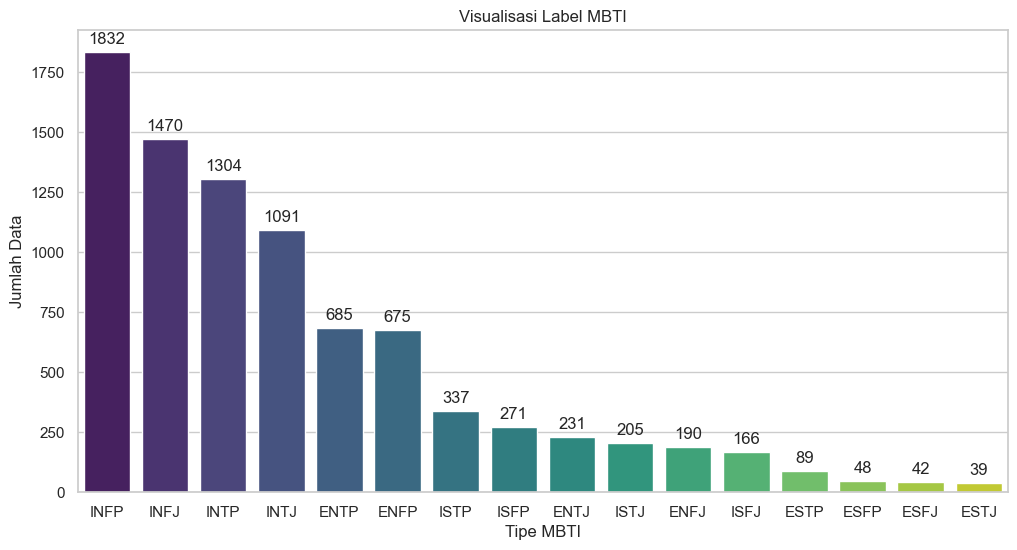

In [6]:
# Visualisasi labels MBTI
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
mbti_counts = dataset['type'].value_counts()
bar_plot = sns.barplot(x=mbti_counts.index, y=mbti_counts.values, palette='viridis')

plt.title('Visualisasi Label MBTI')
plt.xlabel('Tipe MBTI')
plt.ylabel('Jumlah Data')

# Menambahkan angka di atas bar
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.show()

In [7]:
dataset['I/E'] = dataset['type'].apply(lambda x: 'I' if 'I' in x else 'E')
dataset['N/S'] = dataset['type'].apply(lambda x: 'N' if 'N' in x else 'S')
dataset['T/F'] = dataset['type'].apply(lambda x: 'T' if 'T' in x else 'F')
dataset['J/P'] = dataset['type'].apply(lambda x: 'J' if 'J' in x else 'P')

In [8]:
print(dataset.head(10))

   type                                              posts I/E N/S T/F J/P
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   I   N   F   J
1  ENTP  'I'm finding the lack of me in these posts ver...   E   N   T   P
2  INTP  'Good one  _____   https://www.youtube.com/wat...   I   N   T   P
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   I   N   T   J
4  ENTJ  'You're fired.|||That's another silly misconce...   E   N   T   J
5  INTJ  '18/37 @.@|||Science  is not perfect. No scien...   I   N   T   J
6  INFJ  'No, I can't draw on my own nails (haha). Thos...   I   N   F   J
7  INTJ  'I tend to build up a collection of things on ...   I   N   T   J
8  INFJ  I'm not sure, that's a good question. The dist...   I   N   F   J
9  INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...   I   N   T   P


In [9]:
def analisis_tipe_kepribadian(data):
    print("Introverts vs Extroverts:")
    print(data['I/E'].value_counts())
    
    print("\nIntuition vs Sensing:")
    print(data['N/S'].value_counts())

    print("\nThinking vs Feeling:")
    print(data['T/F'].value_counts())

    print("\nJudging vs Perceiving:")
    print(data['J/P'].value_counts())

In [10]:
analisis_tipe_kepribadian(dataset)

Introverts vs Extroverts:
I/E
I    6676
E    1999
Name: count, dtype: int64

Intuition vs Sensing:
N/S
N    7478
S    1197
Name: count, dtype: int64

Thinking vs Feeling:
T/F
F    4694
T    3981
Name: count, dtype: int64

Judging vs Perceiving:
J/P
P    5241
J    3434
Name: count, dtype: int64


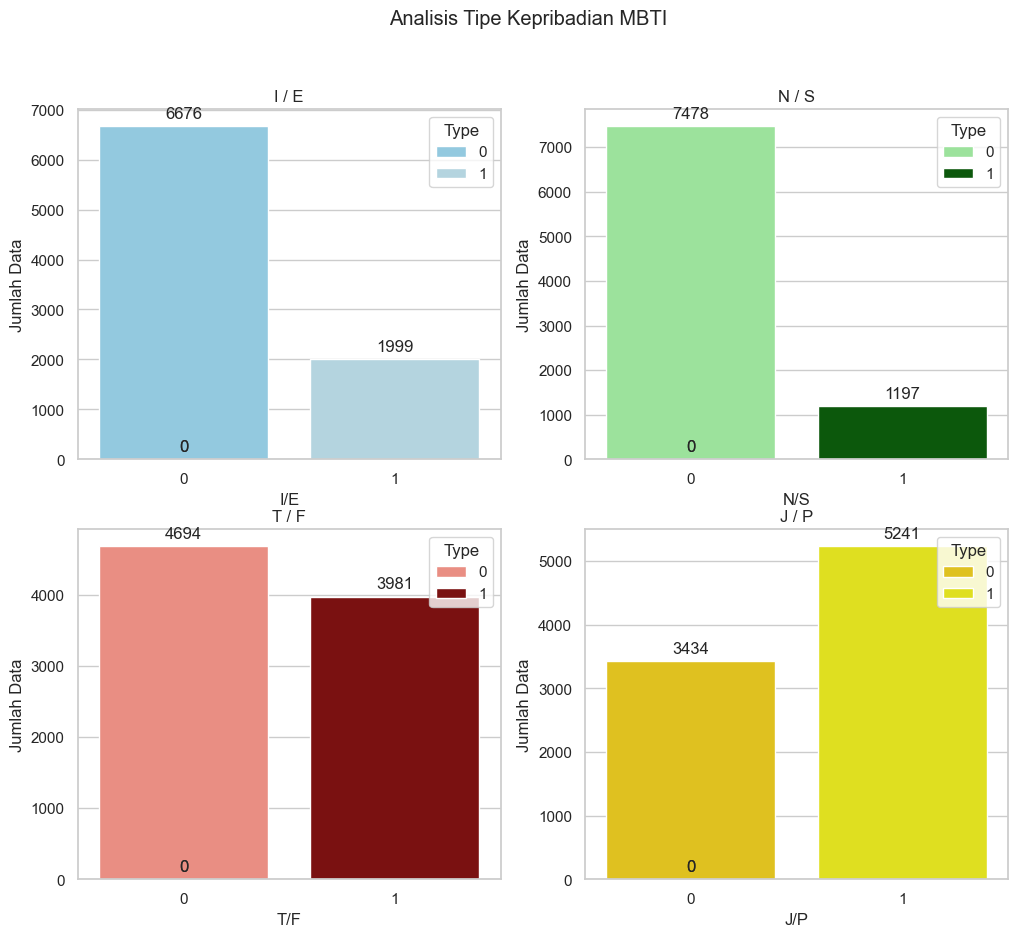

In [14]:
# Memvisualisasikan tipe kepribadian
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Analisis Tipe Kepribadian MBTI')

palettes = {
    'I/E': ['skyblue', 'lightblue'],
    'N/S': ['lightgreen', 'darkgreen'],
    'T/F': ['salmon', 'darkred'],
    'J/P': ['gold', 'yellow']
}

subplots = [(0, 0, 'I/E'), (0, 1, 'N/S'), (1, 0, 'T/F'), (1, 1, 'J/P')]

for row, col, category in subplots:
    ax = axes[row][col]
    plot = sns.countplot(x=category, hue=category, data=dataset, ax=ax, palette=palettes[category])
    ax.set_title(f'{category.split("/")[0]} / {category.split("/")[1]}')
    ax.set_ylabel('Jumlah Data')
    ax.legend(title='Type', loc='upper right')

    # Menambahkan label teks di atas tiap bar
    for p in plot.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

plt.show()

In [12]:
mappings = {'I': 0, 'E': 1, 'N': 0, 'S': 1, 'F': 0, 'T': 1, 'J': 0, 'P': 1}

def convert_to_binary(df):
    for col in ['I/E', 'N/S', 'T/F', 'J/P']:
        df[col] = df[col].map(mappings)
    return df

In [13]:
dataset = convert_to_binary(dataset)
dataset.head(10)

,type,posts,I/E,N/S,T/F,J/P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,0,0,1,0
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",0,0,0,0
7,INTJ,'I tend to build up a collection of things on ...,0,0,1,0
8,INFJ,"I'm not sure, that's a good question. The dist...",0,0,0,0
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,0,0,1,1


In [15]:
# Fungsi Menghapus URL menggunakan regular expression
def hapus_url(text):
    return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

# Fungsi Menghapus karakter non-alfabetik menggunakan regular expression
def hapus_nonalfabet(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Fungsi Mengonversi teks menjadi huruf kecil
def konversi_huruf_kecil(text):
    return text.lower()

# Fungsi Menghapus spasi 
def hapus_spasi(text):
    return ' '.join(text.split())

In [17]:
dataset_url = [hapus_url(post) for post in dataset['posts']]
dataset_nonalfabet = [hapus_nonalfabet(post) for post in dataset_url]
dataset_huruf_kecil = [konversi_huruf_kecil(post) for post in dataset_nonalfabet]
pembersihan_data = [hapus_spasi(post) for post in dataset_huruf_kecil]
# Menyimpan data setelah pembersihan
dataset['posts'] = pembersihan_data

In [23]:
dataset['posts']

0       enfp and intj moments sportscenter not top ten...
1       im finding the lack of me in these posts very ...
2       good one of course to which i say i know thats...
3       dear intp i enjoyed our conversation the other...
4       youre firedthats another silly misconception t...
                              ...                        
8670    ixfp just because i always think of cats as fi...
8671    soif this thread already exists someplace else...
8672    so many questions when i do these things i wou...
8673    i am very conflicted right now when it comes t...
8674    it has been too long since i have been on pers...
Name: posts, Length: 8675, dtype: object

In [24]:
# Analisis Frekuensi kata
analisis_kata = CountVectorizer(stop_words='english')
X = analisis_kata.fit_transform(dataset['posts'])
kata_frekuensi = dict(zip(analisis_kata.get_feature_names_out(), X.sum(axis=0).A1))
kata_frekuensi_df = pd.DataFrame(list(kata_frekuensi.items()), columns=['kata', 'frekuensi']).sort_values(by='frekuensi', ascending=False)
kata_frekuensi_df.head(10)

,kata,frekuensi
153704,like,67149
126200,im,65769
144219,just,52641
69708,dont,50999
269178,think,48648
199605,people,44118
147265,know,35686
218183,really,34032
273026,time,25534
141233,ive,24124


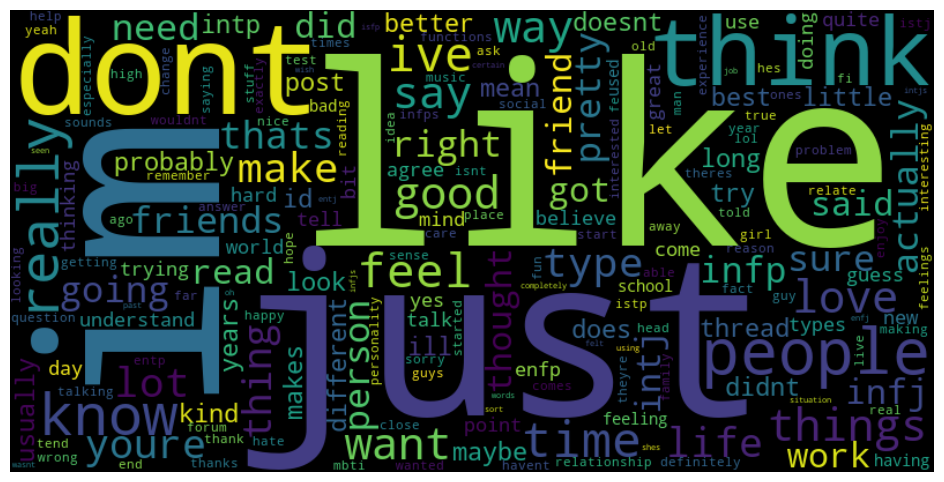

In [25]:
# Visualisasi Frekuensi kata
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(kata_frekuensi)
plt.figure(figsize=(20, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

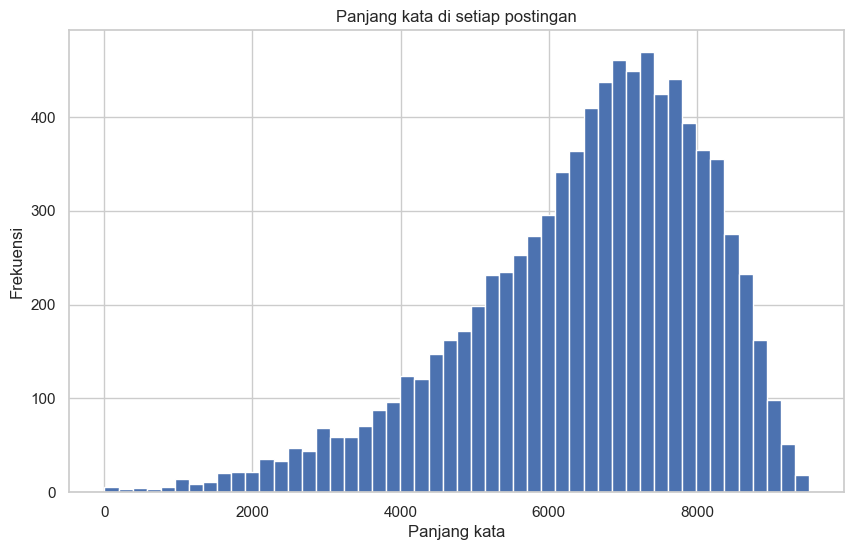

In [26]:
# Analisis panjangan kata
dataset['panjang_kata'] = dataset['posts'].apply(len)
plt.figure(figsize=(10, 6))
dataset['panjang_kata'].hist(bins=50)
plt.title('Panjang kata di setiap postingan')
plt.xlabel('Panjang kata')
plt.ylabel('Frekuensi')
plt.show()

In [29]:
dataset['panjang_kata'].describe()

count    8675.000000
mean     6504.099712
std      1621.220373
min         3.000000
25%      5571.000000
50%      6789.000000
75%      7708.000000
max      9512.000000
Name: panjang_kata, dtype: float64

In [30]:
dataset.head(10)

,type,posts,I/E,N/S,T/F,J/P,panjang_kata
0,INFJ,enfp and intj moments sportscenter not top ten...,0,0,0,0,3079
1,ENTP,im finding the lack of me in these posts very ...,1,0,1,1,5957
2,INTP,good one of course to which i say i know thats...,0,0,1,1,4548
3,INTJ,dear intp i enjoyed our conversation the other...,0,0,1,0,5667
4,ENTJ,youre firedthats another silly misconception t...,1,0,1,0,5322
5,INTJ,science is not perfect no scientist claims tha...,0,0,1,0,7894
6,INFJ,no i cant draw on my own nails haha those were...,0,0,0,0,7087
7,INTJ,i tend to build up a collection of things on m...,0,0,1,0,6397
8,INFJ,im not sure thats a good question the distinct...,0,0,0,0,3916
9,INTP,im in this position where i have to actually l...,0,0,1,1,6816
